In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/street-foods-images/popular_street_foods/dataset_stats.csv
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0106.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0074.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0077.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0058.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0128.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0141.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0053.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0165.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0006.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0095.jpg
/kaggle/input/street-foods-images/popular_street_foods/dataset/poutine/0070.jpg
/kaggle/input/street-foods-images/popular_stree

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T

In [3]:
os.listdir('/kaggle/input/street-foods-images/popular_street_foods')

['dataset', 'dataset_stats.csv']

In [4]:
os.listdir('/kaggle/input/street-foods-images/popular_street_foods/dataset')

['poutine',
 'falafel',
 'arepas',
 'burger',
 'pani_puri',
 'empanadas',
 'fish_and_chips',
 'bánh_mì',
 'kebab_(shish_kebab)',
 'pizza_slice',
 'churros',
 'currywurst',
 'pretzel',
 'shawarma',
 'hot_dog',
 'tacos',
 'crepes',
 'gelato',
 'samosas',
 'pad_thai']

In [5]:
dataset_stats = pd.read_csv('/kaggle/input/street-foods-images/popular_street_foods/dataset_stats.csv')

# Visualise Dataset

Number of classes: 20


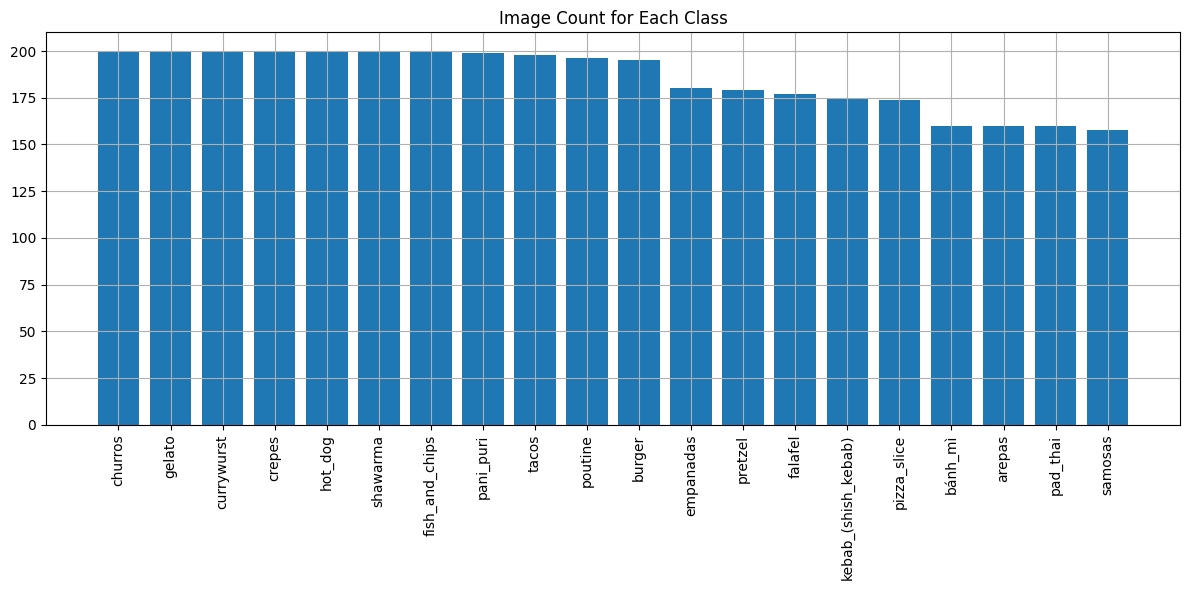

In [6]:
number_of_classes = dataset_stats['class'].nunique()

print(f"Number of classes: {number_of_classes}")

plt.figure(figsize=(12,6))
plt.bar(dataset_stats['class'], dataset_stats['image_count'] )
plt.xticks(rotation='vertical')

plt.title('Image Count for Each Class')
plt.tight_layout()
plt.grid(True)
plt.show()

# Set Seed and CPU Cores

In [7]:
SEED = 42

NUM_WORKERS = os.cpu_count()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device: {device}")
print(f"Number of CPU cores: {NUM_WORKERS}")

Device: cuda
Number of CPU cores: 4


# Set Hyperparameters

In [8]:
EPOCHS = 25
LEARNING_RATE = 0.001
IMG_SIZE = 224
BATCH_SIZE = 32

# Creating my Own Dataset Class

In [9]:
class ImageDatasets(torch.utils.data.Dataset):

    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
            return x, y

    def __len__(self):
        return len(self.subset)

# Load Data

In [10]:
full_dataset = torchvision.datasets.ImageFolder('/kaggle/input/street-foods-images/popular_street_foods/dataset', transform=None)

In [11]:
train_transform = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.2),
    T.RandomGrayscale(p=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = T.Compose([
    T.Resize(int(IMG_SIZE*1.14)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
training_subset, val_subset, testing_subset = torch.utils.data.random_split(full_dataset, 
                                                             [0.8, 0.1, 0.1], 
                                                             generator=torch.Generator().manual_seed(SEED))

In [13]:
training_set = ImageDatasets(subset=training_subset, transform=train_transform)
val_set = ImageDatasets(subset=val_subset, transform=val_test_transform)
testing_set = ImageDatasets(subset=testing_subset, transform=val_test_transform)

In [14]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [15]:
print("First 5 samples from the training dataset")
for i in range(5):
    img, label = training_set[i]
    class_name = full_dataset.classes[label]
    print(f"Sample: {i}, Label: {label}, Class:{class_name}, Shape: {img.size()}")

First 5 samples from the training dataset
Sample: 0, Label: 12, Class:pad_thai, Shape: torch.Size([3, 224, 224])
Sample: 1, Label: 10, Class:hot_dog, Shape: torch.Size([3, 224, 224])
Sample: 2, Label: 4, Class:crepes, Shape: torch.Size([3, 224, 224])
Sample: 3, Label: 11, Class:kebab_(shish_kebab), Shape: torch.Size([3, 224, 224])
Sample: 4, Label: 15, Class:poutine, Shape: torch.Size([3, 224, 224])


In [16]:
print(f"Size of training_set: {len(training_set)} images. Number of batches: {len(training_set) // BATCH_SIZE}")
print(f"Size of val_set: {len(val_set)} images. Number of batches: {len(val_set) // BATCH_SIZE}")
print(f"Size of testing_set: {len(testing_set)} images. Number of batches: {len(testing_set) // BATCH_SIZE}")

Size of training_set: 2940 images. Number of batches: 91
Size of val_set: 367 images. Number of batches: 11
Size of testing_set: 367 images. Number of batches: 11


# Defining Model

In [17]:
class CNN(nn.Module):

    def __init__(self, classes):
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(num_features=16)
        self.gelu_1 = nn.GELU()
        self.maxpool_1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(num_features=32)
        self.gelu_2 = nn.GELU()
        self.maxpool_2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(num_features=64)
        self.gelu_3 = nn.GELU()
        self.maxpool_3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(num_features=128)
        self.gelu_4 = nn.GELU()
        self.maxpool_4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc_1 = nn.Linear(in_features=128, out_features=256)
        self.gelu_5 = nn.GELU()
        self.dropout = nn.Dropout(0.4)
    
        self.fc_2 = nn.Linear(in_features=256, out_features=classes)

    def forward(self,x):
        x = self.conv_1(x)
        x = self.batch_norm_1(x)
        x = self.gelu_1(x)
        x = self.maxpool_1(x)

        x = self.conv_2(x)
        x = self.batch_norm_2(x)
        x = self.gelu_2(x)
        x = self.maxpool_2(x)

        x = self.conv_3(x)
        x = self.batch_norm_3(x)
        x = self.gelu_3(x)
        x = self.maxpool_3(x)

        x = self.conv_4(x)
        x = self.batch_norm_4(x)
        x = self.gelu_4(x)
        x = self.maxpool_4(x)
        
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        
        x = self.fc_1(x)
        x = self.gelu_5(x)
        x = self.dropout(x)

        output = self.fc_2(x)

        return output

model = CNN(classes=number_of_classes)

# Load Loss Function, and Optimiser

In [18]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(),lr = LEARNING_RATE)

# Training Model

In [19]:
model = model.to(device)

In [20]:
history = {
    "epoch_training_loss" : [],
    "training_accuracy" : [],
    "epoch_validation_loss" : [],
    "validation_accuracy" : []
}

In [21]:
for e in range(EPOCHS):
    print(f"CURRENT EPOCH:{e+1}")

    running_training_loss = 0
    running_validation_loss = 0

    training_correct = 0
    validation_correct = 0

    training_total = 0
    validation_total = 0

    # Training

    for j, data in enumerate(train_loader):
        
        img, label = data
        img, label = img.to(device), label.to(device)

        pred = model(img)

        loss = loss_fn(pred, label)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_training_loss += loss.item()
        training_correct += (pred.argmax(1) == label).type(torch.float).sum().item()
        training_total += label.size(0)

    avg_train_loss = round(running_training_loss / len(train_loader), 4)
    history["epoch_training_loss"].append(avg_train_loss)
    history["training_accuracy"].append(round(training_correct / training_total, 4))

    # Validation

    with torch.set_grad_enabled(False):

        for k, data in enumerate(val_loader):

            img, label = data
            img, label = img.to(device), label.to(device)

            pred = model(img)

            loss = loss_fn(pred, label)

            running_validation_loss += loss.item()
            validation_correct += (pred.argmax(1) == label).type(torch.float).sum().item()
            validation_total += label.size(0)

    avg_val_loss = round(running_validation_loss / len(val_loader), 4)
    history["epoch_validation_loss"].append(avg_val_loss)
    history["validation_accuracy"].append(round(validation_correct / validation_total, 4))

print("Training and Validation Complete!")

CURRENT EPOCH:1
CURRENT EPOCH:2
CURRENT EPOCH:3
CURRENT EPOCH:4
CURRENT EPOCH:5
CURRENT EPOCH:6
CURRENT EPOCH:7
CURRENT EPOCH:8
CURRENT EPOCH:9
CURRENT EPOCH:10
CURRENT EPOCH:11
CURRENT EPOCH:12
CURRENT EPOCH:13
CURRENT EPOCH:14
CURRENT EPOCH:15
CURRENT EPOCH:16
CURRENT EPOCH:17
CURRENT EPOCH:18
CURRENT EPOCH:19
CURRENT EPOCH:20
CURRENT EPOCH:21
CURRENT EPOCH:22
CURRENT EPOCH:23
CURRENT EPOCH:24
CURRENT EPOCH:25
Training and Validation Complete!


In [22]:
print(f"Training loss: {history['epoch_training_loss']}")
print(f"Validation loss: {history['epoch_validation_loss']}")

print(f"Training accuracy: {history['training_accuracy']}")
print(f"Validation accuracy: {history['validation_accuracy']}")


Training loss: [2.9329, 2.8096, 2.7612, 2.7154, 2.6957, 2.65, 2.6353, 2.5963, 2.5612, 2.5483, 2.5008, 2.4725, 2.4396, 2.4153, 2.3865, 2.3319, 2.3155, 2.3113, 2.2585, 2.2409, 2.2106, 2.192, 2.1598, 2.1513, 2.1223]
Validation loss: [2.8222, 2.7776, 2.7537, 2.7595, 2.6944, 2.6753, 2.6847, 2.6585, 2.5459, 2.5494, 2.5321, 2.5516, 2.5287, 2.5064, 2.4767, 2.46, 2.4053, 2.3834, 2.4299, 2.4639, 2.3855, 2.3475, 2.3091, 2.3364, 2.3569]
Training accuracy: [0.0854, 0.132, 0.1459, 0.1568, 0.1636, 0.1752, 0.1731, 0.1932, 0.201, 0.1963, 0.2163, 0.2276, 0.2361, 0.2435, 0.2554, 0.2677, 0.2782, 0.2782, 0.3024, 0.2959, 0.3031, 0.3146, 0.3245, 0.3262, 0.3296]
Validation accuracy: [0.1281, 0.1308, 0.1471, 0.1281, 0.1253, 0.1662, 0.1689, 0.1553, 0.1907, 0.2343, 0.2016, 0.2125, 0.2262, 0.2262, 0.2425, 0.248, 0.2534, 0.2807, 0.2616, 0.248, 0.2779, 0.2698, 0.2779, 0.2698, 0.2698]


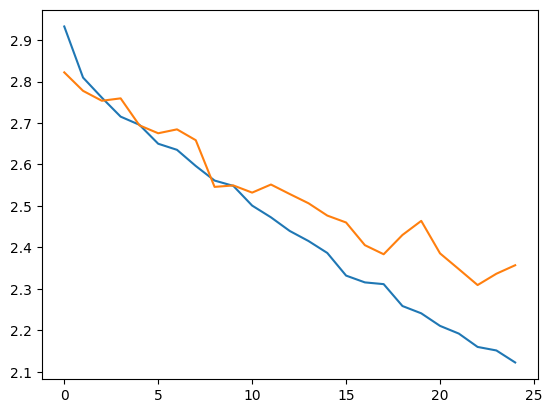

In [23]:
plt.plot(history["epoch_training_loss"])
plt.plot(history["epoch_validation_loss"])

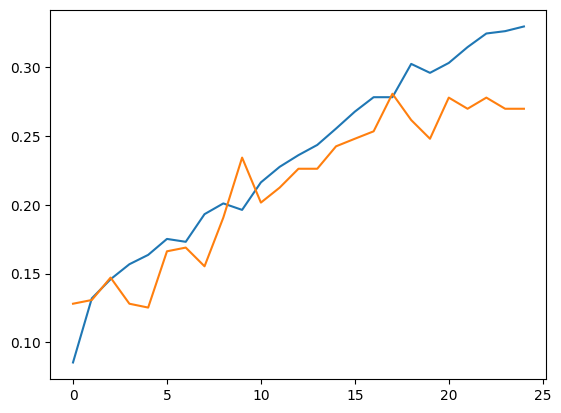

In [24]:
plt.plot(history["training_accuracy"])
plt.plot(history["validation_accuracy"])

# Evaluation

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
all_preds = []
all_labels = []

with torch.set_grad_enabled(False):

    for i, data in enumerate(test_loader):
        img, labels = data
        test_output = model(img.to(device))

        _, predicted = torch.max(test_output.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

In [27]:
accuracy = accuracy_score(all_preds, all_labels)

In [28]:
accuracy

0.2970027247956403